# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [36]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

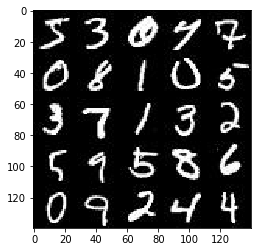

In [37]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

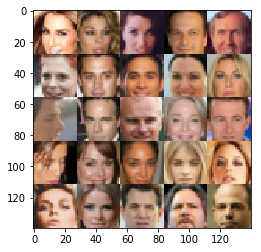

In [38]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [39]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [40]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    inputReal = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    inputZ = tf.placeholder(tf.float32, (None, z_dim))
    learningRate = tf.placeholder(tf.float32, name='learningRate')
    
    return inputReal, inputZ, learningRate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [41]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    # Had problem with dimension on generator and discriminator - used solution from: https://discussions.udacity.com/t/cannot-generate-any-images/250235
    
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha=0.2
        dropOutRate = 0.95
        
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * conv1, conv1)
        dropout1 = tf.nn.dropout(relu1, dropOutRate)

        conv2 = tf.layers.conv2d(dropout1, 128, 5, strides=2, padding='same')
        normalized2 = tf.layers.batch_normalization(conv2, training=True)
        relu2 = tf.maximum(alpha * normalized2, normalized2)
        dropout2 = tf.nn.dropout(relu2, dropOutRate)

        conv3 = tf.layers.conv2d(dropout2, 256, 5, strides=1, padding='same') 
        normalized3 = tf.layers.batch_normalization(conv3, training=True)
        relu3 = tf.maximum(alpha * normalized3, normalized3)
        dropout3 = tf.nn.dropout(relu3, dropOutRate)

        flat = tf.reshape(relu3, (-1, 7*7*256)) 
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)


        return output, logits
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [42]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.2

        lay1 = tf.layers.dense(z, 7*7*256)
        reshaped1 = tf.reshape(lay1, (-1, 7, 7, 256))
        normalized1 = tf.layers.batch_normalization(reshaped1, training=is_train)
        relu1 = tf.maximum(alpha * normalized1, normalized1)
        dropout1 = tf.nn.dropout(relu1, 1)

        lay2 = tf.layers.conv2d_transpose(dropout1, 128, 5, strides=2, padding='same')
        normalized2 = tf.layers.batch_normalization(lay2, training=is_train)
        relu2 = tf.maximum(alpha * normalized2, normalized2)
        dropout2= tf.nn.dropout(relu2, 1)

        lay3 = tf.layers.conv2d_transpose(dropout2, 64, 5, strides=2, padding='same')
        normalized3 = tf.layers.batch_normalization(lay3, training=is_train)
        relu3 = tf.maximum(alpha * normalized3, normalized3)
        dropout3= tf.nn.dropout(relu3, 1)

        logits = tf.layers.conv2d_transpose(dropout3, out_channel_dim, 5, strides=1, padding='same')
        output = tf.tanh(logits)

        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [43]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smoothed = 0.95

    generatorModel = generator(input_z, out_channel_dim, is_train=True)
    modelReal, logitsReal = discriminator(input_real, reuse=False)
    modelFake, logitsFake = discriminator(generatorModel, reuse=True)

    lossReal = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logitsReal, labels=tf.ones_like(modelReal)*smoothed))
    lossFake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logitsFake, labels=tf.zeros_like(modelFake))) 
    generalorLoss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logitsFake, labels=tf.ones_like(modelFake))) 
    discriminatorLoss = lossReal + lossFake


    return discriminatorLoss, generalorLoss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [44]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    variables = tf.trainable_variables()
    discriminatorVariables = [var for var in variables if var.name.startswith('discriminator')]
    generatorVariables = [var for var in variables if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):

        discriminatorOptimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=discriminatorVariables)
        generatorOptymizer = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=generatorVariables)
        return discriminatorOptimizer, generatorOptymizer


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [45]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [46]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    imageWidth = data_shape[1]
    imageHeight = data_shape[2]
    imageChannels = data_shape[3]

    inputReal, inputZ, learningRate = model_inputs(imageWidth, imageHeight, imageChannels, z_dim)
    discriminatorLoss, generalorLoss = model_loss(inputReal, inputZ, imageChannels)
    discriminatorOptimizer, generatorOptymizer = model_opt(discriminatorLoss, generalorLoss, learningRate, beta1)
    
    
    stepsInBatch = data_shape[0] // batch_size
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            step = 0
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                step += 1
                batch_images = batch_images * 2.0
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                _ = sess.run(discriminatorOptimizer, feed_dict={inputZ: batch_z, inputReal: batch_images, learningRate: learning_rate})
                _ = sess.run(generatorOptymizer, feed_dict={inputZ: batch_z, inputReal: batch_images, learningRate: learning_rate})
                
                if step % 5 == 0:
                    discriminatorLossWhileTraining = discriminatorLoss.eval({inputZ: batch_z, inputReal: batch_images})
                    generatorLossWhileTraining = generalorLoss.eval({inputZ: batch_z})
                    print("Epoch {}/{} - Step {}/{}: ".format(epoch_i+1, epoch_count, step, stepsInBatch),
                         "Discriminator Loss: {}".format(discriminatorLossWhileTraining),
                         "Generator Loss: {}".format(generatorLossWhileTraining))
                if step % 100 == 0 or step == stepsInBatch:
                    show_generator_output(sess, 25, inputZ, imageChannels, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 - Step 5/937:  Discriminator Loss: 0.9298579692840576 Generator Loss: 0.8397954702377319
Epoch 1/2 - Step 10/937:  Discriminator Loss: 0.36718231439590454 Generator Loss: 5.246481418609619
Epoch 1/2 - Step 15/937:  Discriminator Loss: 0.4982384145259857 Generator Loss: 2.853806734085083
Epoch 1/2 - Step 20/937:  Discriminator Loss: 0.3096940219402313 Generator Loss: 3.621279239654541
Epoch 1/2 - Step 25/937:  Discriminator Loss: 0.2744014263153076 Generator Loss: 3.6154613494873047
Epoch 1/2 - Step 30/937:  Discriminator Loss: 0.24749144911766052 Generator Loss: 4.287130832672119
Epoch 1/2 - Step 35/937:  Discriminator Loss: 0.27355441451072693 Generator Loss: 3.191497802734375
Epoch 1/2 - Step 40/937:  Discriminator Loss: 0.9207934141159058 Generator Loss: 1.4870975017547607
Epoch 1/2 - Step 45/937:  Discriminator Loss: 2.512052536010742 Generator Loss: 0.22039854526519775
Epoch 1/2 - Step 50/937:  Discriminator Loss: 4.00179386138916 Generator Loss: 0.315501868724823
Epoch 

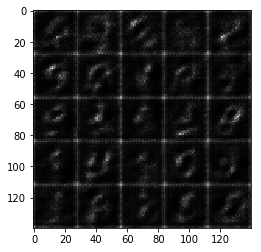

Epoch 1/2 - Step 105/937:  Discriminator Loss: 1.845937967300415 Generator Loss: 1.4212638139724731
Epoch 1/2 - Step 110/937:  Discriminator Loss: 1.4927394390106201 Generator Loss: 0.47913962602615356
Epoch 1/2 - Step 115/937:  Discriminator Loss: 1.2302563190460205 Generator Loss: 1.3889670372009277
Epoch 1/2 - Step 120/937:  Discriminator Loss: 1.5676624774932861 Generator Loss: 0.47835278511047363
Epoch 1/2 - Step 125/937:  Discriminator Loss: 1.4658974409103394 Generator Loss: 1.1583915948867798
Epoch 1/2 - Step 130/937:  Discriminator Loss: 1.436659336090088 Generator Loss: 0.47616785764694214
Epoch 1/2 - Step 135/937:  Discriminator Loss: 1.5616352558135986 Generator Loss: 1.5975666046142578
Epoch 1/2 - Step 140/937:  Discriminator Loss: 1.7076048851013184 Generator Loss: 0.37286683917045593
Epoch 1/2 - Step 145/937:  Discriminator Loss: 1.3218393325805664 Generator Loss: 0.7434359788894653
Epoch 1/2 - Step 150/937:  Discriminator Loss: 1.2583585977554321 Generator Loss: 0.87010

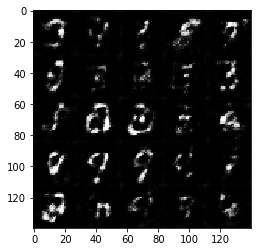

Epoch 1/2 - Step 205/937:  Discriminator Loss: 1.3551719188690186 Generator Loss: 0.6556360721588135
Epoch 1/2 - Step 210/937:  Discriminator Loss: 1.2156214714050293 Generator Loss: 0.7423416376113892
Epoch 1/2 - Step 215/937:  Discriminator Loss: 1.31990385055542 Generator Loss: 0.5728325843811035
Epoch 1/2 - Step 220/937:  Discriminator Loss: 1.3775066137313843 Generator Loss: 1.249230146408081
Epoch 1/2 - Step 225/937:  Discriminator Loss: 1.6076786518096924 Generator Loss: 0.3671726584434509
Epoch 1/2 - Step 230/937:  Discriminator Loss: 1.0822770595550537 Generator Loss: 0.9116048812866211
Epoch 1/2 - Step 235/937:  Discriminator Loss: 1.1600236892700195 Generator Loss: 1.62410569190979
Epoch 1/2 - Step 240/937:  Discriminator Loss: 1.6926801204681396 Generator Loss: 0.3820340037345886
Epoch 1/2 - Step 245/937:  Discriminator Loss: 1.1095187664031982 Generator Loss: 1.450800895690918
Epoch 1/2 - Step 250/937:  Discriminator Loss: 1.210556149482727 Generator Loss: 0.73373675346374

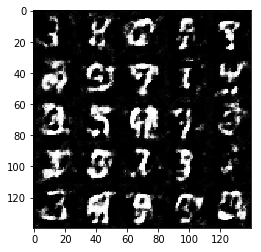

Epoch 1/2 - Step 305/937:  Discriminator Loss: 1.1200778484344482 Generator Loss: 0.6574119925498962
Epoch 1/2 - Step 310/937:  Discriminator Loss: 1.046964406967163 Generator Loss: 0.7553818225860596
Epoch 1/2 - Step 315/937:  Discriminator Loss: 1.0889654159545898 Generator Loss: 1.4978618621826172
Epoch 1/2 - Step 320/937:  Discriminator Loss: 1.6352789402008057 Generator Loss: 0.37442097067832947
Epoch 1/2 - Step 325/937:  Discriminator Loss: 0.9180067777633667 Generator Loss: 0.9624675512313843
Epoch 1/2 - Step 330/937:  Discriminator Loss: 0.9347042441368103 Generator Loss: 1.164053201675415
Epoch 1/2 - Step 335/937:  Discriminator Loss: 1.3579643964767456 Generator Loss: 0.5024905204772949
Epoch 1/2 - Step 340/937:  Discriminator Loss: 0.9176895618438721 Generator Loss: 1.1235735416412354
Epoch 1/2 - Step 345/937:  Discriminator Loss: 0.9144401550292969 Generator Loss: 0.9367831945419312
Epoch 1/2 - Step 350/937:  Discriminator Loss: 1.2441978454589844 Generator Loss: 0.64842498

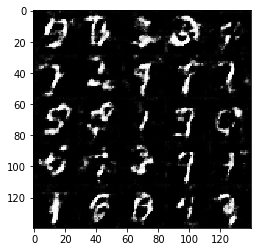

Epoch 1/2 - Step 405/937:  Discriminator Loss: 1.0213196277618408 Generator Loss: 2.287266731262207
Epoch 1/2 - Step 410/937:  Discriminator Loss: 0.9134349822998047 Generator Loss: 1.2475652694702148
Epoch 1/2 - Step 415/937:  Discriminator Loss: 1.4204761981964111 Generator Loss: 2.620049476623535
Epoch 1/2 - Step 420/937:  Discriminator Loss: 0.8975252509117126 Generator Loss: 1.2172956466674805
Epoch 1/2 - Step 425/937:  Discriminator Loss: 1.094965934753418 Generator Loss: 0.8681743144989014
Epoch 1/2 - Step 430/937:  Discriminator Loss: 1.5449720621109009 Generator Loss: 2.3781158924102783
Epoch 1/2 - Step 435/937:  Discriminator Loss: 1.0147929191589355 Generator Loss: 1.1698572635650635
Epoch 1/2 - Step 440/937:  Discriminator Loss: 1.1497249603271484 Generator Loss: 0.6305590271949768
Epoch 1/2 - Step 445/937:  Discriminator Loss: 1.4589468240737915 Generator Loss: 2.592679023742676
Epoch 1/2 - Step 450/937:  Discriminator Loss: 1.0003881454467773 Generator Loss: 1.02146685123

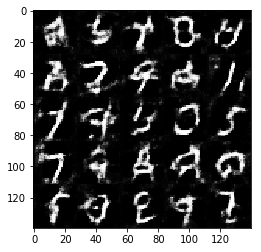

Epoch 1/2 - Step 505/937:  Discriminator Loss: 1.2499957084655762 Generator Loss: 0.5829073190689087
Epoch 1/2 - Step 510/937:  Discriminator Loss: 1.717100977897644 Generator Loss: 2.3031740188598633
Epoch 1/2 - Step 515/937:  Discriminator Loss: 1.1094353199005127 Generator Loss: 1.0519840717315674
Epoch 1/2 - Step 520/937:  Discriminator Loss: 1.6448529958724976 Generator Loss: 0.3219851553440094
Epoch 1/2 - Step 525/937:  Discriminator Loss: 1.0112941265106201 Generator Loss: 1.2947189807891846
Epoch 1/2 - Step 530/937:  Discriminator Loss: 1.2530934810638428 Generator Loss: 1.9998770952224731
Epoch 1/2 - Step 535/937:  Discriminator Loss: 1.303494930267334 Generator Loss: 0.5984551906585693
Epoch 1/2 - Step 540/937:  Discriminator Loss: 1.2816059589385986 Generator Loss: 0.5646381378173828
Epoch 1/2 - Step 545/937:  Discriminator Loss: 0.9942154288291931 Generator Loss: 1.1749358177185059
Epoch 1/2 - Step 550/937:  Discriminator Loss: 1.046398639678955 Generator Loss: 1.3665783405

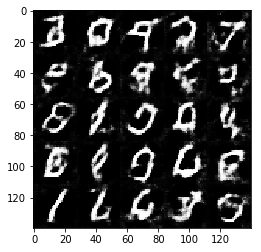

Epoch 1/2 - Step 605/937:  Discriminator Loss: 1.0965162515640259 Generator Loss: 0.7659597396850586
Epoch 1/2 - Step 610/937:  Discriminator Loss: 1.0518863201141357 Generator Loss: 1.3049989938735962
Epoch 1/2 - Step 615/937:  Discriminator Loss: 1.6471898555755615 Generator Loss: 0.3670126795768738
Epoch 1/2 - Step 620/937:  Discriminator Loss: 1.1915167570114136 Generator Loss: 1.4989551305770874
Epoch 1/2 - Step 625/937:  Discriminator Loss: 1.0965051651000977 Generator Loss: 0.8578134775161743
Epoch 1/2 - Step 630/937:  Discriminator Loss: 1.2739486694335938 Generator Loss: 0.6077913045883179
Epoch 1/2 - Step 635/937:  Discriminator Loss: 1.0819900035858154 Generator Loss: 1.4304041862487793
Epoch 1/2 - Step 640/937:  Discriminator Loss: 1.2325154542922974 Generator Loss: 0.5648045539855957
Epoch 1/2 - Step 645/937:  Discriminator Loss: 1.0402820110321045 Generator Loss: 0.797670304775238
Epoch 1/2 - Step 650/937:  Discriminator Loss: 1.4646791219711304 Generator Loss: 1.66772878

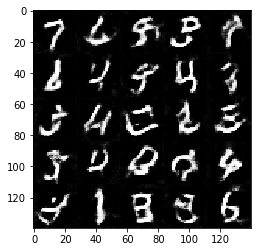

Epoch 1/2 - Step 705/937:  Discriminator Loss: 1.8864768743515015 Generator Loss: 0.2546021342277527
Epoch 1/2 - Step 710/937:  Discriminator Loss: 1.0109246969223022 Generator Loss: 0.9095393419265747
Epoch 1/2 - Step 715/937:  Discriminator Loss: 0.9798890352249146 Generator Loss: 1.5111074447631836
Epoch 1/2 - Step 720/937:  Discriminator Loss: 1.1227883100509644 Generator Loss: 1.407509207725525
Epoch 1/2 - Step 725/937:  Discriminator Loss: 1.3598902225494385 Generator Loss: 0.5091887712478638
Epoch 1/2 - Step 730/937:  Discriminator Loss: 1.0972168445587158 Generator Loss: 1.3839319944381714
Epoch 1/2 - Step 735/937:  Discriminator Loss: 1.093098521232605 Generator Loss: 1.100480556488037
Epoch 1/2 - Step 740/937:  Discriminator Loss: 1.3859115839004517 Generator Loss: 0.4118131995201111
Epoch 1/2 - Step 745/937:  Discriminator Loss: 1.4158884286880493 Generator Loss: 0.476111501455307
Epoch 1/2 - Step 750/937:  Discriminator Loss: 0.928978443145752 Generator Loss: 1.206542253494

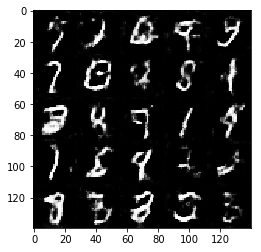

Epoch 1/2 - Step 805/937:  Discriminator Loss: 1.3389054536819458 Generator Loss: 1.8669710159301758
Epoch 1/2 - Step 810/937:  Discriminator Loss: 1.1352262496948242 Generator Loss: 0.8270251750946045
Epoch 1/2 - Step 815/937:  Discriminator Loss: 1.000169277191162 Generator Loss: 1.3249821662902832
Epoch 1/2 - Step 820/937:  Discriminator Loss: 1.1107364892959595 Generator Loss: 0.8270977139472961
Epoch 1/2 - Step 825/937:  Discriminator Loss: 0.8466088175773621 Generator Loss: 1.310495138168335
Epoch 1/2 - Step 830/937:  Discriminator Loss: 1.20473051071167 Generator Loss: 0.5702853798866272
Epoch 1/2 - Step 835/937:  Discriminator Loss: 1.1453797817230225 Generator Loss: 0.7194229364395142
Epoch 1/2 - Step 840/937:  Discriminator Loss: 0.6340910792350769 Generator Loss: 1.7772855758666992
Epoch 1/2 - Step 845/937:  Discriminator Loss: 2.0607471466064453 Generator Loss: 0.262357234954834
Epoch 1/2 - Step 850/937:  Discriminator Loss: 0.9350390434265137 Generator Loss: 1.079605698585

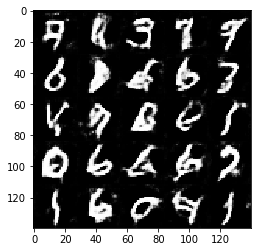

Epoch 1/2 - Step 905/937:  Discriminator Loss: 1.1762034893035889 Generator Loss: 0.6896169185638428
Epoch 1/2 - Step 910/937:  Discriminator Loss: 1.2434096336364746 Generator Loss: 0.6373254060745239
Epoch 1/2 - Step 915/937:  Discriminator Loss: 1.1537302732467651 Generator Loss: 1.6303507089614868
Epoch 1/2 - Step 920/937:  Discriminator Loss: 1.3810019493103027 Generator Loss: 0.4918338358402252
Epoch 1/2 - Step 925/937:  Discriminator Loss: 1.0107680559158325 Generator Loss: 1.1034070253372192
Epoch 1/2 - Step 930/937:  Discriminator Loss: 1.023658037185669 Generator Loss: 0.8622103929519653
Epoch 1/2 - Step 935/937:  Discriminator Loss: 0.8551851511001587 Generator Loss: 1.2907453775405884


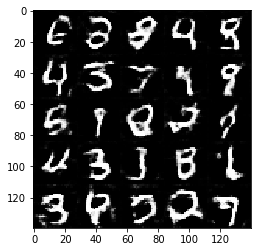

Epoch 2/2 - Step 5/937:  Discriminator Loss: 0.9370165467262268 Generator Loss: 0.8439178466796875
Epoch 2/2 - Step 10/937:  Discriminator Loss: 1.4199597835540771 Generator Loss: 2.0119543075561523
Epoch 2/2 - Step 15/937:  Discriminator Loss: 1.0567665100097656 Generator Loss: 1.2449991703033447
Epoch 2/2 - Step 20/937:  Discriminator Loss: 1.453800082206726 Generator Loss: 0.45760035514831543
Epoch 2/2 - Step 25/937:  Discriminator Loss: 1.1124653816223145 Generator Loss: 0.8142268657684326
Epoch 2/2 - Step 30/937:  Discriminator Loss: 1.5173399448394775 Generator Loss: 0.4326532483100891
Epoch 2/2 - Step 35/937:  Discriminator Loss: 1.007601261138916 Generator Loss: 1.153066873550415
Epoch 2/2 - Step 40/937:  Discriminator Loss: 1.0509064197540283 Generator Loss: 1.2974958419799805
Epoch 2/2 - Step 45/937:  Discriminator Loss: 1.2956781387329102 Generator Loss: 2.1036417484283447
Epoch 2/2 - Step 50/937:  Discriminator Loss: 1.4522888660430908 Generator Loss: 0.47864481806755066
Ep

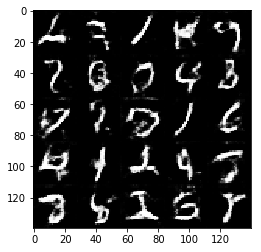

Epoch 2/2 - Step 105/937:  Discriminator Loss: 2.385281801223755 Generator Loss: 0.22131748497486115
Epoch 2/2 - Step 110/937:  Discriminator Loss: 2.2363500595092773 Generator Loss: 3.32090425491333
Epoch 2/2 - Step 115/937:  Discriminator Loss: 1.258258581161499 Generator Loss: 0.5742443203926086
Epoch 2/2 - Step 120/937:  Discriminator Loss: 1.1276071071624756 Generator Loss: 0.826225996017456
Epoch 2/2 - Step 125/937:  Discriminator Loss: 0.9775368571281433 Generator Loss: 0.8344342708587646
Epoch 2/2 - Step 130/937:  Discriminator Loss: 0.8464914560317993 Generator Loss: 0.9906682372093201
Epoch 2/2 - Step 135/937:  Discriminator Loss: 1.1076099872589111 Generator Loss: 0.7740185260772705
Epoch 2/2 - Step 140/937:  Discriminator Loss: 0.9551361799240112 Generator Loss: 1.3762328624725342
Epoch 2/2 - Step 145/937:  Discriminator Loss: 1.5248157978057861 Generator Loss: 0.4424518346786499
Epoch 2/2 - Step 150/937:  Discriminator Loss: 1.215681552886963 Generator Loss: 1.040780782699

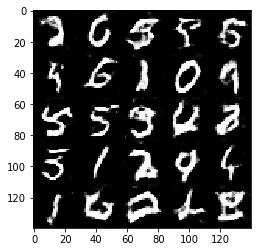

Epoch 2/2 - Step 205/937:  Discriminator Loss: 0.9851788282394409 Generator Loss: 0.7893388271331787
Epoch 2/2 - Step 210/937:  Discriminator Loss: 1.0205644369125366 Generator Loss: 0.7987064123153687
Epoch 2/2 - Step 215/937:  Discriminator Loss: 2.246765613555908 Generator Loss: 2.634751081466675
Epoch 2/2 - Step 220/937:  Discriminator Loss: 1.55182683467865 Generator Loss: 0.5261458158493042
Epoch 2/2 - Step 225/937:  Discriminator Loss: 1.5240858793258667 Generator Loss: 0.39824914932250977
Epoch 2/2 - Step 230/937:  Discriminator Loss: 1.1830753087997437 Generator Loss: 0.7361392974853516
Epoch 2/2 - Step 235/937:  Discriminator Loss: 0.9942959547042847 Generator Loss: 0.8805378079414368
Epoch 2/2 - Step 240/937:  Discriminator Loss: 1.5574183464050293 Generator Loss: 0.46264535188674927
Epoch 2/2 - Step 245/937:  Discriminator Loss: 1.0939695835113525 Generator Loss: 0.8917931318283081
Epoch 2/2 - Step 250/937:  Discriminator Loss: 0.9022514820098877 Generator Loss: 0.932400465

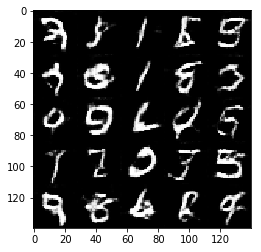

Epoch 2/2 - Step 305/937:  Discriminator Loss: 1.2773442268371582 Generator Loss: 0.607129693031311
Epoch 2/2 - Step 310/937:  Discriminator Loss: 0.8563437461853027 Generator Loss: 1.0819408893585205
Epoch 2/2 - Step 315/937:  Discriminator Loss: 1.2149255275726318 Generator Loss: 0.5321590304374695
Epoch 2/2 - Step 320/937:  Discriminator Loss: 1.1108253002166748 Generator Loss: 1.3991553783416748
Epoch 2/2 - Step 325/937:  Discriminator Loss: 0.7561986446380615 Generator Loss: 1.5699712038040161
Epoch 2/2 - Step 330/937:  Discriminator Loss: 2.4018592834472656 Generator Loss: 0.17565618455410004
Epoch 2/2 - Step 335/937:  Discriminator Loss: 1.6864707469940186 Generator Loss: 0.38199031352996826
Epoch 2/2 - Step 340/937:  Discriminator Loss: 0.9567681550979614 Generator Loss: 1.5655710697174072
Epoch 2/2 - Step 345/937:  Discriminator Loss: 1.4465534687042236 Generator Loss: 0.5524198412895203
Epoch 2/2 - Step 350/937:  Discriminator Loss: 0.8086158037185669 Generator Loss: 1.215179

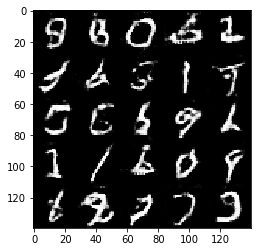

Epoch 2/2 - Step 405/937:  Discriminator Loss: 0.761245846748352 Generator Loss: 1.293203353881836
Epoch 2/2 - Step 410/937:  Discriminator Loss: 0.7868115305900574 Generator Loss: 1.468217372894287
Epoch 2/2 - Step 415/937:  Discriminator Loss: 0.8954331278800964 Generator Loss: 1.0201475620269775
Epoch 2/2 - Step 420/937:  Discriminator Loss: 0.9711918830871582 Generator Loss: 2.327991247177124
Epoch 2/2 - Step 425/937:  Discriminator Loss: 0.8231481313705444 Generator Loss: 1.1690549850463867
Epoch 2/2 - Step 430/937:  Discriminator Loss: 0.8349608778953552 Generator Loss: 1.401558756828308
Epoch 2/2 - Step 435/937:  Discriminator Loss: 1.0134059190750122 Generator Loss: 1.3730037212371826
Epoch 2/2 - Step 440/937:  Discriminator Loss: 1.082302451133728 Generator Loss: 0.7298575639724731
Epoch 2/2 - Step 445/937:  Discriminator Loss: 1.1552066802978516 Generator Loss: 0.6805760264396667
Epoch 2/2 - Step 450/937:  Discriminator Loss: 0.7091661691665649 Generator Loss: 1.8786463737487

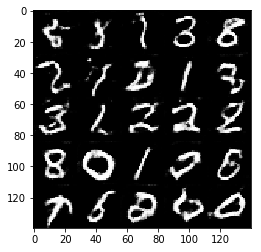

Epoch 2/2 - Step 505/937:  Discriminator Loss: 0.8118139505386353 Generator Loss: 1.4711565971374512
Epoch 2/2 - Step 510/937:  Discriminator Loss: 1.1633166074752808 Generator Loss: 2.166013479232788
Epoch 2/2 - Step 515/937:  Discriminator Loss: 0.8089903593063354 Generator Loss: 1.249859094619751
Epoch 2/2 - Step 520/937:  Discriminator Loss: 0.7756351232528687 Generator Loss: 1.2720720767974854
Epoch 2/2 - Step 525/937:  Discriminator Loss: 0.9523166418075562 Generator Loss: 0.9217742681503296
Epoch 2/2 - Step 530/937:  Discriminator Loss: 0.9183380007743835 Generator Loss: 1.1514191627502441
Epoch 2/2 - Step 535/937:  Discriminator Loss: 1.0272116661071777 Generator Loss: 0.8694299459457397
Epoch 2/2 - Step 540/937:  Discriminator Loss: 1.296272873878479 Generator Loss: 0.5718223452568054
Epoch 2/2 - Step 545/937:  Discriminator Loss: 0.7278710603713989 Generator Loss: 1.995084285736084
Epoch 2/2 - Step 550/937:  Discriminator Loss: 0.7207973003387451 Generator Loss: 1.46963334083

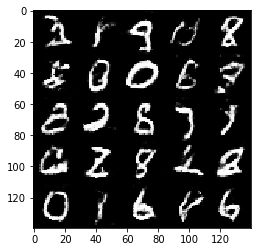

Epoch 2/2 - Step 605/937:  Discriminator Loss: 0.8836140632629395 Generator Loss: 1.0332005023956299
Epoch 2/2 - Step 610/937:  Discriminator Loss: 1.1535158157348633 Generator Loss: 0.8461297154426575
Epoch 2/2 - Step 615/937:  Discriminator Loss: 1.129295825958252 Generator Loss: 0.6922085285186768
Epoch 2/2 - Step 620/937:  Discriminator Loss: 0.9330422282218933 Generator Loss: 1.9882874488830566
Epoch 2/2 - Step 625/937:  Discriminator Loss: 1.091522455215454 Generator Loss: 0.9150489568710327
Epoch 2/2 - Step 630/937:  Discriminator Loss: 1.7019727230072021 Generator Loss: 0.33749544620513916
Epoch 2/2 - Step 635/937:  Discriminator Loss: 0.9014846086502075 Generator Loss: 2.0771431922912598
Epoch 2/2 - Step 640/937:  Discriminator Loss: 1.1338298320770264 Generator Loss: 0.7819874286651611
Epoch 2/2 - Step 645/937:  Discriminator Loss: 0.921928882598877 Generator Loss: 0.8730084896087646
Epoch 2/2 - Step 650/937:  Discriminator Loss: 0.9462212324142456 Generator Loss: 1.340404748

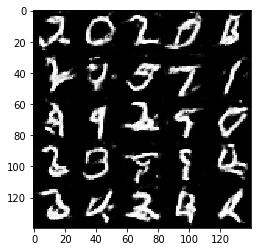

Epoch 2/2 - Step 705/937:  Discriminator Loss: 0.9159115552902222 Generator Loss: 1.0929887294769287
Epoch 2/2 - Step 710/937:  Discriminator Loss: 1.1224876642227173 Generator Loss: 0.7047313451766968
Epoch 2/2 - Step 715/937:  Discriminator Loss: 1.114690899848938 Generator Loss: 0.8300382494926453
Epoch 2/2 - Step 720/937:  Discriminator Loss: 1.0025583505630493 Generator Loss: 1.0482014417648315
Epoch 2/2 - Step 725/937:  Discriminator Loss: 0.8977295160293579 Generator Loss: 1.1688426733016968
Epoch 2/2 - Step 730/937:  Discriminator Loss: 1.115663766860962 Generator Loss: 2.493605613708496
Epoch 2/2 - Step 735/937:  Discriminator Loss: 0.8934429883956909 Generator Loss: 1.852771282196045
Epoch 2/2 - Step 740/937:  Discriminator Loss: 0.8994047045707703 Generator Loss: 0.9759775400161743
Epoch 2/2 - Step 745/937:  Discriminator Loss: 1.0950068235397339 Generator Loss: 1.7897865772247314
Epoch 2/2 - Step 750/937:  Discriminator Loss: 1.2828772068023682 Generator Loss: 0.59086954593

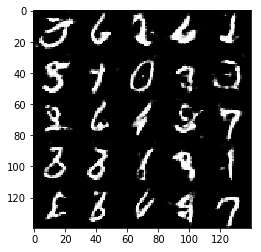

Epoch 2/2 - Step 805/937:  Discriminator Loss: 0.9019356966018677 Generator Loss: 1.6037230491638184
Epoch 2/2 - Step 810/937:  Discriminator Loss: 1.5937575101852417 Generator Loss: 2.9213435649871826
Epoch 2/2 - Step 815/937:  Discriminator Loss: 1.1580177545547485 Generator Loss: 0.74689781665802
Epoch 2/2 - Step 820/937:  Discriminator Loss: 0.7763880491256714 Generator Loss: 1.6849145889282227
Epoch 2/2 - Step 825/937:  Discriminator Loss: 0.7529202103614807 Generator Loss: 2.012190341949463
Epoch 2/2 - Step 830/937:  Discriminator Loss: 1.4388794898986816 Generator Loss: 0.5011301040649414
Epoch 2/2 - Step 835/937:  Discriminator Loss: 1.1045804023742676 Generator Loss: 0.9189763069152832
Epoch 2/2 - Step 840/937:  Discriminator Loss: 0.5689908862113953 Generator Loss: 2.042478561401367
Epoch 2/2 - Step 845/937:  Discriminator Loss: 1.6440366506576538 Generator Loss: 0.4635836184024811
Epoch 2/2 - Step 850/937:  Discriminator Loss: 0.7412559390068054 Generator Loss: 1.78129637241

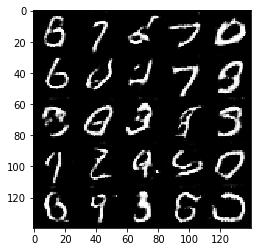

Epoch 2/2 - Step 905/937:  Discriminator Loss: 1.3186578750610352 Generator Loss: 0.5933103561401367
Epoch 2/2 - Step 910/937:  Discriminator Loss: 0.8679475784301758 Generator Loss: 1.206817865371704
Epoch 2/2 - Step 915/937:  Discriminator Loss: 1.1081995964050293 Generator Loss: 1.1158543825149536
Epoch 2/2 - Step 920/937:  Discriminator Loss: 0.9752726554870605 Generator Loss: 0.9986779093742371
Epoch 2/2 - Step 925/937:  Discriminator Loss: 0.7651897668838501 Generator Loss: 1.214994192123413
Epoch 2/2 - Step 930/937:  Discriminator Loss: 0.8000646233558655 Generator Loss: 1.228666067123413
Epoch 2/2 - Step 935/937:  Discriminator Loss: 0.7608392238616943 Generator Loss: 1.3017160892486572


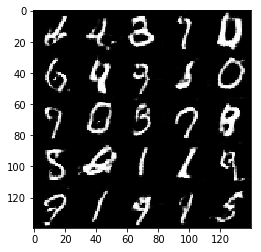

In [49]:
batch_size = 64
z_dim = 200
learning_rate = 0.00025
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1 - Step 5/3165:  Discriminator Loss: 1.1945525407791138 Generator Loss: 0.7630035877227783
Epoch 1/1 - Step 10/3165:  Discriminator Loss: 0.8567832708358765 Generator Loss: 1.2850110530853271
Epoch 1/1 - Step 15/3165:  Discriminator Loss: 1.5853379964828491 Generator Loss: 0.5194420218467712
Epoch 1/1 - Step 20/3165:  Discriminator Loss: 0.5463268756866455 Generator Loss: 2.0961790084838867
Epoch 1/1 - Step 25/3165:  Discriminator Loss: 5.543698787689209 Generator Loss: 0.021559273824095726
Epoch 1/1 - Step 30/3165:  Discriminator Loss: 0.8545345664024353 Generator Loss: 5.812164783477783
Epoch 1/1 - Step 35/3165:  Discriminator Loss: 1.3956298828125 Generator Loss: 1.9638054370880127
Epoch 1/1 - Step 40/3165:  Discriminator Loss: 1.8366018533706665 Generator Loss: 0.43212437629699707
Epoch 1/1 - Step 45/3165:  Discriminator Loss: 1.4722470045089722 Generator Loss: 3.6443419456481934
Epoch 1/1 - Step 50/3165:  Discriminator Loss: 1.6445059776306152 Generator Loss: 0.4301761388

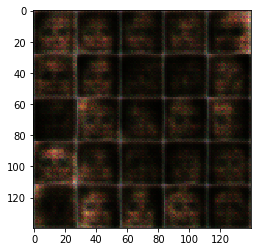

Epoch 1/1 - Step 105/3165:  Discriminator Loss: 0.5589665770530701 Generator Loss: 2.9682841300964355
Epoch 1/1 - Step 110/3165:  Discriminator Loss: 1.713529109954834 Generator Loss: 0.3642685115337372
Epoch 1/1 - Step 115/3165:  Discriminator Loss: 1.3956756591796875 Generator Loss: 4.264280796051025
Epoch 1/1 - Step 120/3165:  Discriminator Loss: 0.6529103517532349 Generator Loss: 1.361633539199829
Epoch 1/1 - Step 125/3165:  Discriminator Loss: 1.453783631324768 Generator Loss: 0.4628126621246338
Epoch 1/1 - Step 130/3165:  Discriminator Loss: 1.0869355201721191 Generator Loss: 5.53870964050293
Epoch 1/1 - Step 135/3165:  Discriminator Loss: 1.406052827835083 Generator Loss: 0.5091670751571655
Epoch 1/1 - Step 140/3165:  Discriminator Loss: 0.7694119215011597 Generator Loss: 3.7832257747650146
Epoch 1/1 - Step 145/3165:  Discriminator Loss: 0.498539537191391 Generator Loss: 1.7741518020629883
Epoch 1/1 - Step 150/3165:  Discriminator Loss: 1.5782136917114258 Generator Loss: 4.64356

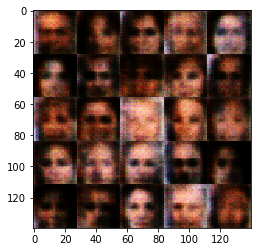

Epoch 1/1 - Step 205/3165:  Discriminator Loss: 0.8209553956985474 Generator Loss: 3.938385009765625
Epoch 1/1 - Step 210/3165:  Discriminator Loss: 0.48369330167770386 Generator Loss: 2.1395316123962402
Epoch 1/1 - Step 215/3165:  Discriminator Loss: 1.5806190967559814 Generator Loss: 0.41248226165771484
Epoch 1/1 - Step 220/3165:  Discriminator Loss: 1.0082402229309082 Generator Loss: 3.0649261474609375
Epoch 1/1 - Step 225/3165:  Discriminator Loss: 0.84101402759552 Generator Loss: 1.150995135307312
Epoch 1/1 - Step 230/3165:  Discriminator Loss: 0.8729066252708435 Generator Loss: 3.4634456634521484
Epoch 1/1 - Step 235/3165:  Discriminator Loss: 1.0440397262573242 Generator Loss: 1.0711616277694702
Epoch 1/1 - Step 240/3165:  Discriminator Loss: 0.784845232963562 Generator Loss: 0.9222457408905029
Epoch 1/1 - Step 245/3165:  Discriminator Loss: 0.8440786004066467 Generator Loss: 1.7271032333374023
Epoch 1/1 - Step 250/3165:  Discriminator Loss: 0.8556288480758667 Generator Loss: 1.

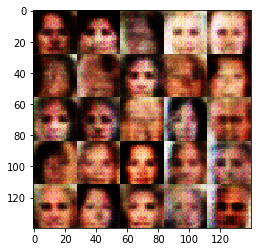

Epoch 1/1 - Step 305/3165:  Discriminator Loss: 0.6523450613021851 Generator Loss: 1.3907066583633423
Epoch 1/1 - Step 310/3165:  Discriminator Loss: 1.832140326499939 Generator Loss: 5.407829761505127
Epoch 1/1 - Step 315/3165:  Discriminator Loss: 0.4070934057235718 Generator Loss: 3.5966107845306396
Epoch 1/1 - Step 320/3165:  Discriminator Loss: 1.0034000873565674 Generator Loss: 0.9286673069000244
Epoch 1/1 - Step 325/3165:  Discriminator Loss: 0.6085238456726074 Generator Loss: 1.7385225296020508
Epoch 1/1 - Step 330/3165:  Discriminator Loss: 1.8698532581329346 Generator Loss: 2.6895394325256348
Epoch 1/1 - Step 335/3165:  Discriminator Loss: 0.7704579830169678 Generator Loss: 1.117387056350708
Epoch 1/1 - Step 340/3165:  Discriminator Loss: 1.451527714729309 Generator Loss: 2.5830233097076416
Epoch 1/1 - Step 345/3165:  Discriminator Loss: 0.7286279797554016 Generator Loss: 1.4463145732879639
Epoch 1/1 - Step 350/3165:  Discriminator Loss: 2.5373289585113525 Generator Loss: 4.3

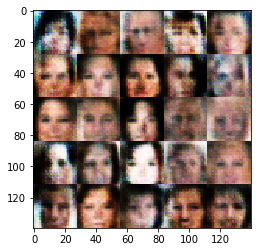

Epoch 1/1 - Step 405/3165:  Discriminator Loss: 1.1113320589065552 Generator Loss: 3.2724509239196777
Epoch 1/1 - Step 410/3165:  Discriminator Loss: 0.9119194149971008 Generator Loss: 0.8543018102645874
Epoch 1/1 - Step 415/3165:  Discriminator Loss: 1.6149406433105469 Generator Loss: 0.34281593561172485
Epoch 1/1 - Step 420/3165:  Discriminator Loss: 1.166778802871704 Generator Loss: 3.3892714977264404
Epoch 1/1 - Step 425/3165:  Discriminator Loss: 0.6355597972869873 Generator Loss: 1.5231322050094604
Epoch 1/1 - Step 430/3165:  Discriminator Loss: 1.1039141416549683 Generator Loss: 0.6184881329536438
Epoch 1/1 - Step 435/3165:  Discriminator Loss: 0.8849196434020996 Generator Loss: 0.8331729173660278
Epoch 1/1 - Step 440/3165:  Discriminator Loss: 0.6358200907707214 Generator Loss: 4.027878761291504
Epoch 1/1 - Step 445/3165:  Discriminator Loss: 0.503667950630188 Generator Loss: 2.1126203536987305
Epoch 1/1 - Step 450/3165:  Discriminator Loss: 0.4828970432281494 Generator Loss: 1

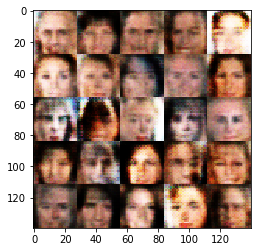

Epoch 1/1 - Step 505/3165:  Discriminator Loss: 1.230400562286377 Generator Loss: 0.5295892953872681
Epoch 1/1 - Step 510/3165:  Discriminator Loss: 0.4182661175727844 Generator Loss: 2.220879554748535
Epoch 1/1 - Step 515/3165:  Discriminator Loss: 1.662908911705017 Generator Loss: 0.3586360216140747
Epoch 1/1 - Step 520/3165:  Discriminator Loss: 0.5997719764709473 Generator Loss: 2.582550287246704
Epoch 1/1 - Step 525/3165:  Discriminator Loss: 1.2245094776153564 Generator Loss: 0.6476267576217651
Epoch 1/1 - Step 530/3165:  Discriminator Loss: 1.9930782318115234 Generator Loss: 2.316897392272949
Epoch 1/1 - Step 535/3165:  Discriminator Loss: 0.5581451654434204 Generator Loss: 1.4459717273712158
Epoch 1/1 - Step 540/3165:  Discriminator Loss: 1.3143751621246338 Generator Loss: 0.5217397212982178
Epoch 1/1 - Step 545/3165:  Discriminator Loss: 1.239441156387329 Generator Loss: 4.505519866943359
Epoch 1/1 - Step 550/3165:  Discriminator Loss: 2.1163744926452637 Generator Loss: 0.2165

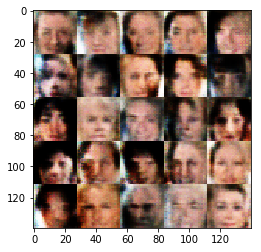

Epoch 1/1 - Step 605/3165:  Discriminator Loss: 0.796425461769104 Generator Loss: 4.693290710449219
Epoch 1/1 - Step 610/3165:  Discriminator Loss: 1.1620477437973022 Generator Loss: 5.084197044372559
Epoch 1/1 - Step 615/3165:  Discriminator Loss: 1.1949127912521362 Generator Loss: 0.5933905839920044
Epoch 1/1 - Step 620/3165:  Discriminator Loss: 0.48543527722358704 Generator Loss: 2.559635639190674
Epoch 1/1 - Step 625/3165:  Discriminator Loss: 0.32095909118652344 Generator Loss: 2.6542677879333496
Epoch 1/1 - Step 630/3165:  Discriminator Loss: 2.1172540187835693 Generator Loss: 1.9233763217926025
Epoch 1/1 - Step 635/3165:  Discriminator Loss: 1.1017698049545288 Generator Loss: 1.04376220703125
Epoch 1/1 - Step 640/3165:  Discriminator Loss: 0.9641367197036743 Generator Loss: 1.1299389600753784
Epoch 1/1 - Step 645/3165:  Discriminator Loss: 0.9224585890769958 Generator Loss: 2.1438846588134766
Epoch 1/1 - Step 650/3165:  Discriminator Loss: 0.54793781042099 Generator Loss: 4.476

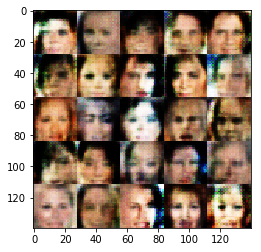

Epoch 1/1 - Step 705/3165:  Discriminator Loss: 0.41637903451919556 Generator Loss: 1.8754324913024902
Epoch 1/1 - Step 710/3165:  Discriminator Loss: 1.2122751474380493 Generator Loss: 0.5500882863998413
Epoch 1/1 - Step 715/3165:  Discriminator Loss: 0.8380114436149597 Generator Loss: 0.8642035722732544
Epoch 1/1 - Step 720/3165:  Discriminator Loss: 0.5009119510650635 Generator Loss: 3.2049667835235596
Epoch 1/1 - Step 725/3165:  Discriminator Loss: 0.7088620662689209 Generator Loss: 2.686213970184326
Epoch 1/1 - Step 730/3165:  Discriminator Loss: 1.1011767387390137 Generator Loss: 0.6547202467918396
Epoch 1/1 - Step 735/3165:  Discriminator Loss: 1.44740629196167 Generator Loss: 0.42937910556793213
Epoch 1/1 - Step 740/3165:  Discriminator Loss: 1.1206997632980347 Generator Loss: 0.6245937347412109
Epoch 1/1 - Step 745/3165:  Discriminator Loss: 1.8042868375778198 Generator Loss: 0.2712554633617401
Epoch 1/1 - Step 750/3165:  Discriminator Loss: 0.7075764536857605 Generator Loss: 

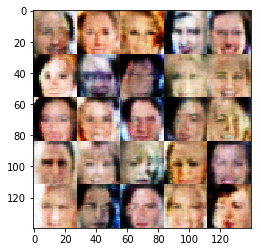

Epoch 1/1 - Step 805/3165:  Discriminator Loss: 0.9433966875076294 Generator Loss: 1.0176472663879395
Epoch 1/1 - Step 810/3165:  Discriminator Loss: 0.7251797914505005 Generator Loss: 2.575671672821045
Epoch 1/1 - Step 815/3165:  Discriminator Loss: 0.4491775631904602 Generator Loss: 2.9534196853637695
Epoch 1/1 - Step 820/3165:  Discriminator Loss: 0.41675177216529846 Generator Loss: 2.164867877960205
Epoch 1/1 - Step 825/3165:  Discriminator Loss: 1.1017093658447266 Generator Loss: 0.6357319951057434
Epoch 1/1 - Step 830/3165:  Discriminator Loss: 2.619178056716919 Generator Loss: 2.6517045497894287
Epoch 1/1 - Step 835/3165:  Discriminator Loss: 0.5746846795082092 Generator Loss: 2.9234931468963623
Epoch 1/1 - Step 840/3165:  Discriminator Loss: 0.5379918813705444 Generator Loss: 1.549253225326538
Epoch 1/1 - Step 845/3165:  Discriminator Loss: 0.5475348234176636 Generator Loss: 1.5674954652786255
Epoch 1/1 - Step 850/3165:  Discriminator Loss: 0.3637450039386749 Generator Loss: 3.

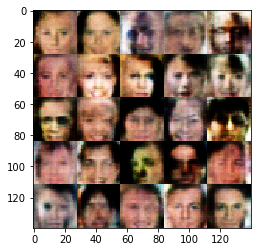

Epoch 1/1 - Step 905/3165:  Discriminator Loss: 0.5012692213058472 Generator Loss: 3.688505172729492
Epoch 1/1 - Step 910/3165:  Discriminator Loss: 0.3004123568534851 Generator Loss: 4.313151836395264
Epoch 1/1 - Step 915/3165:  Discriminator Loss: 0.985077440738678 Generator Loss: 0.7439664006233215
Epoch 1/1 - Step 920/3165:  Discriminator Loss: 2.0097248554229736 Generator Loss: 2.563725471496582
Epoch 1/1 - Step 925/3165:  Discriminator Loss: 0.4611205756664276 Generator Loss: 1.8586655855178833
Epoch 1/1 - Step 930/3165:  Discriminator Loss: 1.3709839582443237 Generator Loss: 2.6858162879943848
Epoch 1/1 - Step 935/3165:  Discriminator Loss: 1.659203052520752 Generator Loss: 0.34590908885002136
Epoch 1/1 - Step 940/3165:  Discriminator Loss: 0.6529244184494019 Generator Loss: 1.7443163394927979
Epoch 1/1 - Step 945/3165:  Discriminator Loss: 0.4276385009288788 Generator Loss: 2.3624024391174316
Epoch 1/1 - Step 950/3165:  Discriminator Loss: 0.769760251045227 Generator Loss: 3.32

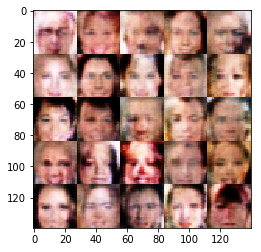

Epoch 1/1 - Step 1005/3165:  Discriminator Loss: 0.3751177489757538 Generator Loss: 3.275514841079712
Epoch 1/1 - Step 1010/3165:  Discriminator Loss: 0.39061111211776733 Generator Loss: 3.154208183288574
Epoch 1/1 - Step 1015/3165:  Discriminator Loss: 0.6535458564758301 Generator Loss: 1.2613041400909424
Epoch 1/1 - Step 1020/3165:  Discriminator Loss: 0.3468444347381592 Generator Loss: 2.624375343322754
Epoch 1/1 - Step 1025/3165:  Discriminator Loss: 1.158515453338623 Generator Loss: 0.6853488683700562
Epoch 1/1 - Step 1030/3165:  Discriminator Loss: 1.4332833290100098 Generator Loss: 0.48925748467445374
Epoch 1/1 - Step 1035/3165:  Discriminator Loss: 1.1115695238113403 Generator Loss: 3.083347797393799
Epoch 1/1 - Step 1040/3165:  Discriminator Loss: 0.5700668096542358 Generator Loss: 1.391204595565796
Epoch 1/1 - Step 1045/3165:  Discriminator Loss: 0.6767539381980896 Generator Loss: 5.665913105010986
Epoch 1/1 - Step 1050/3165:  Discriminator Loss: 0.75136399269104 Generator Lo

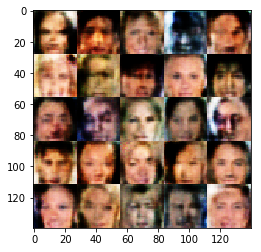

Epoch 1/1 - Step 1105/3165:  Discriminator Loss: 0.42509791254997253 Generator Loss: 4.693498134613037
Epoch 1/1 - Step 1110/3165:  Discriminator Loss: 1.4100282192230225 Generator Loss: 2.1088883876800537
Epoch 1/1 - Step 1115/3165:  Discriminator Loss: 1.1583499908447266 Generator Loss: 0.6360493898391724
Epoch 1/1 - Step 1120/3165:  Discriminator Loss: 1.0689091682434082 Generator Loss: 3.7728824615478516
Epoch 1/1 - Step 1125/3165:  Discriminator Loss: 0.8063676953315735 Generator Loss: 1.059985637664795
Epoch 1/1 - Step 1130/3165:  Discriminator Loss: 1.0438485145568848 Generator Loss: 0.6788469552993774
Epoch 1/1 - Step 1135/3165:  Discriminator Loss: 0.6137862205505371 Generator Loss: 1.6668224334716797
Epoch 1/1 - Step 1140/3165:  Discriminator Loss: 0.8081210255622864 Generator Loss: 5.360462188720703
Epoch 1/1 - Step 1145/3165:  Discriminator Loss: 0.5006943941116333 Generator Loss: 1.516080617904663
Epoch 1/1 - Step 1150/3165:  Discriminator Loss: 1.4597039222717285 Generato

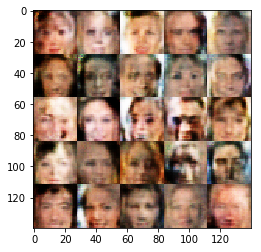

Epoch 1/1 - Step 1205/3165:  Discriminator Loss: 0.4985264241695404 Generator Loss: 1.9354640245437622
Epoch 1/1 - Step 1210/3165:  Discriminator Loss: 0.3442966043949127 Generator Loss: 4.195436477661133
Epoch 1/1 - Step 1215/3165:  Discriminator Loss: 0.2764320969581604 Generator Loss: 3.803450107574463
Epoch 1/1 - Step 1220/3165:  Discriminator Loss: 1.207330584526062 Generator Loss: 0.6280693411827087
Epoch 1/1 - Step 1225/3165:  Discriminator Loss: 1.4017363786697388 Generator Loss: 2.165257453918457
Epoch 1/1 - Step 1230/3165:  Discriminator Loss: 1.0733070373535156 Generator Loss: 0.793572187423706
Epoch 1/1 - Step 1235/3165:  Discriminator Loss: 0.8543129563331604 Generator Loss: 1.7955626249313354
Epoch 1/1 - Step 1240/3165:  Discriminator Loss: 1.5108442306518555 Generator Loss: 0.39122211933135986
Epoch 1/1 - Step 1245/3165:  Discriminator Loss: 0.3687005043029785 Generator Loss: 2.2930662631988525
Epoch 1/1 - Step 1250/3165:  Discriminator Loss: 2.009549379348755 Generator 

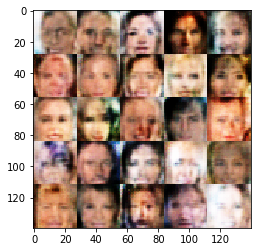

Epoch 1/1 - Step 1305/3165:  Discriminator Loss: 0.6433547735214233 Generator Loss: 1.2581286430358887
Epoch 1/1 - Step 1310/3165:  Discriminator Loss: 0.6277769207954407 Generator Loss: 1.4899168014526367
Epoch 1/1 - Step 1315/3165:  Discriminator Loss: 0.428455114364624 Generator Loss: 1.7923353910446167
Epoch 1/1 - Step 1320/3165:  Discriminator Loss: 1.9190878868103027 Generator Loss: 2.2422096729278564
Epoch 1/1 - Step 1325/3165:  Discriminator Loss: 1.5570281744003296 Generator Loss: 0.38789504766464233
Epoch 1/1 - Step 1330/3165:  Discriminator Loss: 1.0251623392105103 Generator Loss: 0.7285659313201904
Epoch 1/1 - Step 1335/3165:  Discriminator Loss: 0.7824570536613464 Generator Loss: 1.0060886144638062
Epoch 1/1 - Step 1340/3165:  Discriminator Loss: 0.6740585565567017 Generator Loss: 4.485072612762451
Epoch 1/1 - Step 1345/3165:  Discriminator Loss: 0.5120861530303955 Generator Loss: 1.8098758459091187
Epoch 1/1 - Step 1350/3165:  Discriminator Loss: 0.46316859126091003 Gener

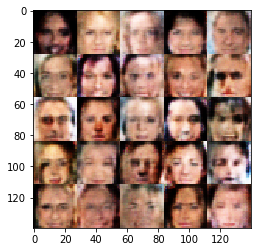

Epoch 1/1 - Step 1405/3165:  Discriminator Loss: 0.9622227549552917 Generator Loss: 0.7548401355743408
Epoch 1/1 - Step 1410/3165:  Discriminator Loss: 1.5375553369522095 Generator Loss: 0.3852100670337677
Epoch 1/1 - Step 1415/3165:  Discriminator Loss: 0.7526162266731262 Generator Loss: 1.007530927658081
Epoch 1/1 - Step 1420/3165:  Discriminator Loss: 0.5593398213386536 Generator Loss: 2.382279396057129
Epoch 1/1 - Step 1425/3165:  Discriminator Loss: 0.34955888986587524 Generator Loss: 2.764221429824829
Epoch 1/1 - Step 1430/3165:  Discriminator Loss: 0.6014686822891235 Generator Loss: 1.383613109588623
Epoch 1/1 - Step 1435/3165:  Discriminator Loss: 0.5525758266448975 Generator Loss: 1.3130662441253662
Epoch 1/1 - Step 1440/3165:  Discriminator Loss: 0.5948788523674011 Generator Loss: 2.827648162841797
Epoch 1/1 - Step 1445/3165:  Discriminator Loss: 1.8977798223495483 Generator Loss: 0.2967323660850525
Epoch 1/1 - Step 1450/3165:  Discriminator Loss: 1.351238489151001 Generator 

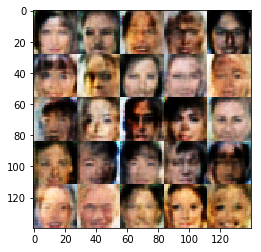

Epoch 1/1 - Step 1505/3165:  Discriminator Loss: 0.5471381545066833 Generator Loss: 2.501532554626465
Epoch 1/1 - Step 1510/3165:  Discriminator Loss: 0.47689157724380493 Generator Loss: 3.340838670730591
Epoch 1/1 - Step 1515/3165:  Discriminator Loss: 0.3343639373779297 Generator Loss: 3.0338969230651855
Epoch 1/1 - Step 1520/3165:  Discriminator Loss: 1.7904484272003174 Generator Loss: 3.967127799987793
Epoch 1/1 - Step 1525/3165:  Discriminator Loss: 1.4649038314819336 Generator Loss: 0.43560177087783813
Epoch 1/1 - Step 1530/3165:  Discriminator Loss: 0.5453377962112427 Generator Loss: 1.586166262626648
Epoch 1/1 - Step 1535/3165:  Discriminator Loss: 1.4290320873260498 Generator Loss: 0.3965098261833191
Epoch 1/1 - Step 1540/3165:  Discriminator Loss: 0.5242377519607544 Generator Loss: 2.2082555294036865
Epoch 1/1 - Step 1545/3165:  Discriminator Loss: 0.5432847738265991 Generator Loss: 1.4419524669647217
Epoch 1/1 - Step 1550/3165:  Discriminator Loss: 0.4777831435203552 Generat

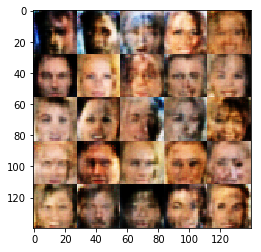

Epoch 1/1 - Step 1605/3165:  Discriminator Loss: 1.2033089399337769 Generator Loss: 1.475417137145996
Epoch 1/1 - Step 1610/3165:  Discriminator Loss: 0.7749435901641846 Generator Loss: 1.1016969680786133
Epoch 1/1 - Step 1615/3165:  Discriminator Loss: 0.9928892254829407 Generator Loss: 1.8229724168777466
Epoch 1/1 - Step 1620/3165:  Discriminator Loss: 1.3081669807434082 Generator Loss: 0.4908231496810913
Epoch 1/1 - Step 1625/3165:  Discriminator Loss: 0.8192031979560852 Generator Loss: 5.03398323059082
Epoch 1/1 - Step 1630/3165:  Discriminator Loss: 1.5304757356643677 Generator Loss: 0.3732081949710846
Epoch 1/1 - Step 1635/3165:  Discriminator Loss: 1.0011200904846191 Generator Loss: 1.0657238960266113
Epoch 1/1 - Step 1640/3165:  Discriminator Loss: 0.9740918874740601 Generator Loss: 1.09585702419281
Epoch 1/1 - Step 1645/3165:  Discriminator Loss: 0.6052291393280029 Generator Loss: 2.202908992767334
Epoch 1/1 - Step 1650/3165:  Discriminator Loss: 0.4338913857936859 Generator L

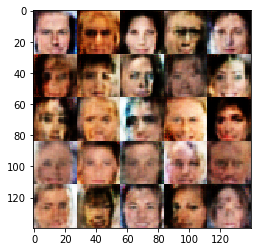

Epoch 1/1 - Step 1705/3165:  Discriminator Loss: 0.6734645962715149 Generator Loss: 1.2302359342575073
Epoch 1/1 - Step 1710/3165:  Discriminator Loss: 1.1608035564422607 Generator Loss: 0.5362316370010376
Epoch 1/1 - Step 1715/3165:  Discriminator Loss: 2.4341492652893066 Generator Loss: 0.17314940690994263
Epoch 1/1 - Step 1720/3165:  Discriminator Loss: 1.0980651378631592 Generator Loss: 1.3027780055999756
Epoch 1/1 - Step 1725/3165:  Discriminator Loss: 1.3864346742630005 Generator Loss: 0.4249832332134247
Epoch 1/1 - Step 1730/3165:  Discriminator Loss: 0.9358060956001282 Generator Loss: 2.378267526626587
Epoch 1/1 - Step 1735/3165:  Discriminator Loss: 0.6347289085388184 Generator Loss: 2.045314311981201
Epoch 1/1 - Step 1740/3165:  Discriminator Loss: 1.2765631675720215 Generator Loss: 0.460922509431839
Epoch 1/1 - Step 1745/3165:  Discriminator Loss: 1.0308263301849365 Generator Loss: 0.7168293595314026
Epoch 1/1 - Step 1750/3165:  Discriminator Loss: 1.1405543088912964 Generat

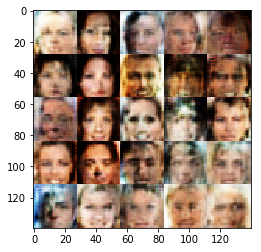

Epoch 1/1 - Step 1805/3165:  Discriminator Loss: 0.5087563991546631 Generator Loss: 2.227126359939575
Epoch 1/1 - Step 1810/3165:  Discriminator Loss: 1.440600872039795 Generator Loss: 0.3700292110443115
Epoch 1/1 - Step 1815/3165:  Discriminator Loss: 1.2447097301483154 Generator Loss: 2.8096768856048584
Epoch 1/1 - Step 1820/3165:  Discriminator Loss: 1.1536448001861572 Generator Loss: 0.6153916120529175
Epoch 1/1 - Step 1825/3165:  Discriminator Loss: 0.8155028223991394 Generator Loss: 2.843982219696045
Epoch 1/1 - Step 1830/3165:  Discriminator Loss: 3.231355905532837 Generator Loss: 3.591169834136963
Epoch 1/1 - Step 1835/3165:  Discriminator Loss: 1.1136188507080078 Generator Loss: 1.2732179164886475
Epoch 1/1 - Step 1840/3165:  Discriminator Loss: 1.0580112934112549 Generator Loss: 0.7571808099746704
Epoch 1/1 - Step 1845/3165:  Discriminator Loss: 1.55601966381073 Generator Loss: 3.407740354537964
Epoch 1/1 - Step 1850/3165:  Discriminator Loss: 0.9298030734062195 Generator Los

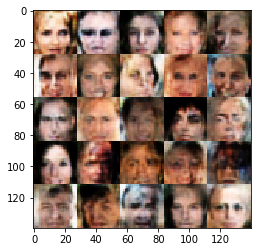

Epoch 1/1 - Step 1905/3165:  Discriminator Loss: 0.9123169183731079 Generator Loss: 1.8782126903533936
Epoch 1/1 - Step 1910/3165:  Discriminator Loss: 1.1548221111297607 Generator Loss: 0.6612367033958435
Epoch 1/1 - Step 1915/3165:  Discriminator Loss: 0.9279612302780151 Generator Loss: 3.3426921367645264
Epoch 1/1 - Step 1920/3165:  Discriminator Loss: 0.440091073513031 Generator Loss: 1.8896455764770508
Epoch 1/1 - Step 1925/3165:  Discriminator Loss: 0.926655113697052 Generator Loss: 0.9805078506469727
Epoch 1/1 - Step 1930/3165:  Discriminator Loss: 1.7776870727539062 Generator Loss: 0.30052387714385986
Epoch 1/1 - Step 1935/3165:  Discriminator Loss: 0.9858152866363525 Generator Loss: 1.280242919921875
Epoch 1/1 - Step 1940/3165:  Discriminator Loss: 0.9871881008148193 Generator Loss: 0.8163629770278931
Epoch 1/1 - Step 1945/3165:  Discriminator Loss: 1.538553237915039 Generator Loss: 3.081609010696411
Epoch 1/1 - Step 1950/3165:  Discriminator Loss: 1.1467205286026 Generator Lo

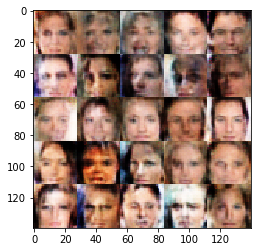

Epoch 1/1 - Step 2005/3165:  Discriminator Loss: 0.6618780493736267 Generator Loss: 1.5006128549575806
Epoch 1/1 - Step 2010/3165:  Discriminator Loss: 0.648852527141571 Generator Loss: 1.6718202829360962
Epoch 1/1 - Step 2015/3165:  Discriminator Loss: 1.1328802108764648 Generator Loss: 0.6902737617492676
Epoch 1/1 - Step 2020/3165:  Discriminator Loss: 1.7669132947921753 Generator Loss: 3.4377195835113525
Epoch 1/1 - Step 2025/3165:  Discriminator Loss: 0.47828221321105957 Generator Loss: 1.7380599975585938
Epoch 1/1 - Step 2030/3165:  Discriminator Loss: 1.6835439205169678 Generator Loss: 0.3025360107421875
Epoch 1/1 - Step 2035/3165:  Discriminator Loss: 1.0156147480010986 Generator Loss: 0.8675870895385742
Epoch 1/1 - Step 2040/3165:  Discriminator Loss: 1.604500412940979 Generator Loss: 2.5201690196990967
Epoch 1/1 - Step 2045/3165:  Discriminator Loss: 1.3312547206878662 Generator Loss: 0.5684115886688232
Epoch 1/1 - Step 2050/3165:  Discriminator Loss: 0.6698566675186157 Genera

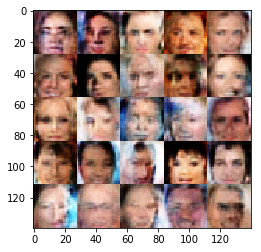

Epoch 1/1 - Step 2105/3165:  Discriminator Loss: 0.6094496250152588 Generator Loss: 1.397085189819336
Epoch 1/1 - Step 2110/3165:  Discriminator Loss: 1.7753024101257324 Generator Loss: 0.29775935411453247
Epoch 1/1 - Step 2115/3165:  Discriminator Loss: 0.8149310350418091 Generator Loss: 1.0062166452407837
Epoch 1/1 - Step 2120/3165:  Discriminator Loss: 0.8962834477424622 Generator Loss: 0.8239773511886597
Epoch 1/1 - Step 2125/3165:  Discriminator Loss: 0.7678321599960327 Generator Loss: 1.2731566429138184
Epoch 1/1 - Step 2130/3165:  Discriminator Loss: 0.515863299369812 Generator Loss: 2.4524269104003906
Epoch 1/1 - Step 2135/3165:  Discriminator Loss: 0.6953034996986389 Generator Loss: 1.309751033782959
Epoch 1/1 - Step 2140/3165:  Discriminator Loss: 1.6540405750274658 Generator Loss: 0.33133530616760254
Epoch 1/1 - Step 2145/3165:  Discriminator Loss: 0.560049295425415 Generator Loss: 2.2830469608306885
Epoch 1/1 - Step 2150/3165:  Discriminator Loss: 0.6163825392723083 Generat

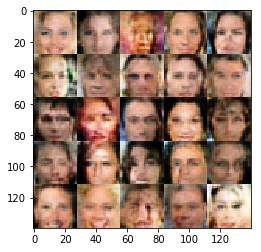

Epoch 1/1 - Step 2205/3165:  Discriminator Loss: 1.3375831842422485 Generator Loss: 2.611237049102783
Epoch 1/1 - Step 2210/3165:  Discriminator Loss: 1.2361665964126587 Generator Loss: 0.5585134029388428
Epoch 1/1 - Step 2215/3165:  Discriminator Loss: 0.4909130930900574 Generator Loss: 2.256135940551758
Epoch 1/1 - Step 2220/3165:  Discriminator Loss: 0.820405125617981 Generator Loss: 0.9271196722984314
Epoch 1/1 - Step 2225/3165:  Discriminator Loss: 1.5277938842773438 Generator Loss: 0.3773537278175354
Epoch 1/1 - Step 2230/3165:  Discriminator Loss: 0.9931260347366333 Generator Loss: 0.9348385334014893
Epoch 1/1 - Step 2235/3165:  Discriminator Loss: 1.0904375314712524 Generator Loss: 0.6478077173233032
Epoch 1/1 - Step 2240/3165:  Discriminator Loss: 0.6826082468032837 Generator Loss: 1.1846423149108887
Epoch 1/1 - Step 2245/3165:  Discriminator Loss: 1.1936694383621216 Generator Loss: 1.8611531257629395
Epoch 1/1 - Step 2250/3165:  Discriminator Loss: 1.0831409692764282 Generato

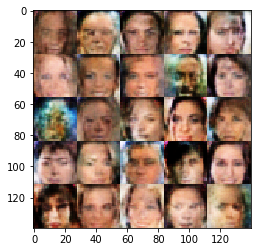

Epoch 1/1 - Step 2305/3165:  Discriminator Loss: 0.7294225692749023 Generator Loss: 1.2355315685272217
Epoch 1/1 - Step 2310/3165:  Discriminator Loss: 1.2965939044952393 Generator Loss: 0.4898480772972107
Epoch 1/1 - Step 2315/3165:  Discriminator Loss: 1.7732505798339844 Generator Loss: 0.3131588101387024
Epoch 1/1 - Step 2320/3165:  Discriminator Loss: 0.9590518474578857 Generator Loss: 1.6880943775177002
Epoch 1/1 - Step 2325/3165:  Discriminator Loss: 0.5826354026794434 Generator Loss: 2.7523255348205566
Epoch 1/1 - Step 2330/3165:  Discriminator Loss: 1.287081003189087 Generator Loss: 2.861645460128784
Epoch 1/1 - Step 2335/3165:  Discriminator Loss: 1.1908400058746338 Generator Loss: 0.6627095341682434
Epoch 1/1 - Step 2340/3165:  Discriminator Loss: 1.1282720565795898 Generator Loss: 0.7147579193115234
Epoch 1/1 - Step 2345/3165:  Discriminator Loss: 1.2702685594558716 Generator Loss: 1.4118132591247559
Epoch 1/1 - Step 2350/3165:  Discriminator Loss: 0.7686323523521423 Generat

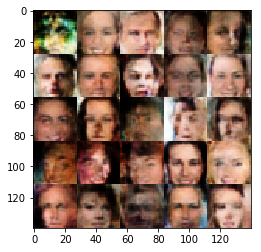

Epoch 1/1 - Step 2405/3165:  Discriminator Loss: 0.5837427377700806 Generator Loss: 1.5345667600631714
Epoch 1/1 - Step 2410/3165:  Discriminator Loss: 0.8154774904251099 Generator Loss: 0.9018142223358154
Epoch 1/1 - Step 2415/3165:  Discriminator Loss: 1.1411720514297485 Generator Loss: 0.6249649524688721
Epoch 1/1 - Step 2420/3165:  Discriminator Loss: 1.058821678161621 Generator Loss: 1.9352695941925049
Epoch 1/1 - Step 2425/3165:  Discriminator Loss: 0.5618504285812378 Generator Loss: 1.6685535907745361
Epoch 1/1 - Step 2430/3165:  Discriminator Loss: 0.4779662489891052 Generator Loss: 1.896653175354004
Epoch 1/1 - Step 2435/3165:  Discriminator Loss: 1.7704967260360718 Generator Loss: 0.3312498927116394
Epoch 1/1 - Step 2440/3165:  Discriminator Loss: 2.614560604095459 Generator Loss: 3.959242820739746
Epoch 1/1 - Step 2445/3165:  Discriminator Loss: 1.0545070171356201 Generator Loss: 0.8304213285446167
Epoch 1/1 - Step 2450/3165:  Discriminator Loss: 1.123703956604004 Generator 

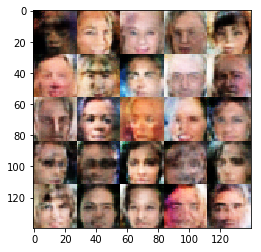

Epoch 1/1 - Step 2505/3165:  Discriminator Loss: 0.9465504884719849 Generator Loss: 0.7950029373168945
Epoch 1/1 - Step 2510/3165:  Discriminator Loss: 1.064427375793457 Generator Loss: 1.579886555671692
Epoch 1/1 - Step 2515/3165:  Discriminator Loss: 0.8186123967170715 Generator Loss: 0.8832001686096191
Epoch 1/1 - Step 2520/3165:  Discriminator Loss: 1.3818340301513672 Generator Loss: 2.1681976318359375
Epoch 1/1 - Step 2525/3165:  Discriminator Loss: 1.1889166831970215 Generator Loss: 1.627631664276123
Epoch 1/1 - Step 2530/3165:  Discriminator Loss: 0.9386007189750671 Generator Loss: 0.804354727268219
Epoch 1/1 - Step 2535/3165:  Discriminator Loss: 0.6203153133392334 Generator Loss: 1.3357360363006592
Epoch 1/1 - Step 2540/3165:  Discriminator Loss: 0.6595017313957214 Generator Loss: 1.1122288703918457
Epoch 1/1 - Step 2545/3165:  Discriminator Loss: 1.6677231788635254 Generator Loss: 0.3202705979347229
Epoch 1/1 - Step 2550/3165:  Discriminator Loss: 1.523184061050415 Generator 

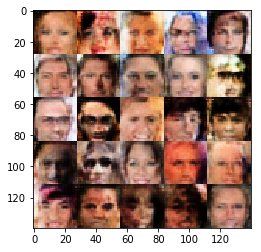

Epoch 1/1 - Step 2605/3165:  Discriminator Loss: 1.4624552726745605 Generator Loss: 0.39589688181877136
Epoch 1/1 - Step 2610/3165:  Discriminator Loss: 1.1947141885757446 Generator Loss: 0.5908575057983398
Epoch 1/1 - Step 2615/3165:  Discriminator Loss: 0.48530247807502747 Generator Loss: 1.6485503911972046
Epoch 1/1 - Step 2620/3165:  Discriminator Loss: 1.4993447065353394 Generator Loss: 0.4687952697277069
Epoch 1/1 - Step 2625/3165:  Discriminator Loss: 1.07550048828125 Generator Loss: 1.675360918045044
Epoch 1/1 - Step 2630/3165:  Discriminator Loss: 0.8811399936676025 Generator Loss: 1.179724097251892
Epoch 1/1 - Step 2635/3165:  Discriminator Loss: 0.45634588599205017 Generator Loss: 1.9233487844467163
Epoch 1/1 - Step 2640/3165:  Discriminator Loss: 2.557689666748047 Generator Loss: 3.2038958072662354
Epoch 1/1 - Step 2645/3165:  Discriminator Loss: 0.5008144974708557 Generator Loss: 2.197737693786621
Epoch 1/1 - Step 2650/3165:  Discriminator Loss: 0.8775346875190735 Generato

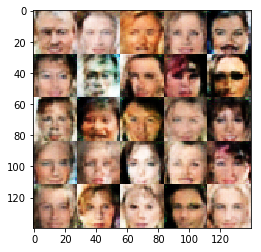

Epoch 1/1 - Step 2705/3165:  Discriminator Loss: 1.491105079650879 Generator Loss: 1.912461757659912
Epoch 1/1 - Step 2710/3165:  Discriminator Loss: 0.625080943107605 Generator Loss: 1.6104695796966553
Epoch 1/1 - Step 2715/3165:  Discriminator Loss: 1.0573232173919678 Generator Loss: 0.7923097610473633
Epoch 1/1 - Step 2720/3165:  Discriminator Loss: 1.2807857990264893 Generator Loss: 0.648222804069519
Epoch 1/1 - Step 2725/3165:  Discriminator Loss: 1.5336819887161255 Generator Loss: 0.3975380063056946
Epoch 1/1 - Step 2730/3165:  Discriminator Loss: 1.4488506317138672 Generator Loss: 2.0390520095825195
Epoch 1/1 - Step 2735/3165:  Discriminator Loss: 1.3553316593170166 Generator Loss: 0.5071437954902649
Epoch 1/1 - Step 2740/3165:  Discriminator Loss: 1.6046942472457886 Generator Loss: 3.4859354496002197
Epoch 1/1 - Step 2745/3165:  Discriminator Loss: 1.6116511821746826 Generator Loss: 0.3578357994556427
Epoch 1/1 - Step 2750/3165:  Discriminator Loss: 1.2141131162643433 Generator

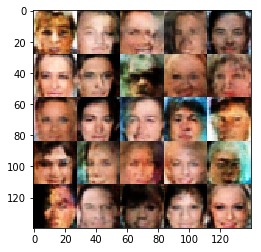

Epoch 1/1 - Step 2805/3165:  Discriminator Loss: 1.3167130947113037 Generator Loss: 0.4594358801841736
Epoch 1/1 - Step 2810/3165:  Discriminator Loss: 1.0656588077545166 Generator Loss: 0.639752209186554
Epoch 1/1 - Step 2815/3165:  Discriminator Loss: 1.3872485160827637 Generator Loss: 1.2006477117538452
Epoch 1/1 - Step 2820/3165:  Discriminator Loss: 0.7027033567428589 Generator Loss: 1.0874590873718262
Epoch 1/1 - Step 2825/3165:  Discriminator Loss: 1.0931134223937988 Generator Loss: 0.6625829935073853
Epoch 1/1 - Step 2830/3165:  Discriminator Loss: 0.8977944850921631 Generator Loss: 0.9816780090332031
Epoch 1/1 - Step 2835/3165:  Discriminator Loss: 0.5724947452545166 Generator Loss: 1.575659990310669
Epoch 1/1 - Step 2840/3165:  Discriminator Loss: 1.237701654434204 Generator Loss: 1.004987120628357
Epoch 1/1 - Step 2845/3165:  Discriminator Loss: 1.4315941333770752 Generator Loss: 0.46548545360565186
Epoch 1/1 - Step 2850/3165:  Discriminator Loss: 1.420854926109314 Generator

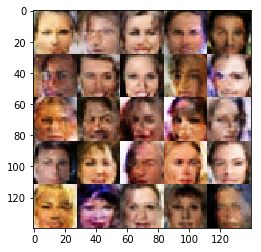

Epoch 1/1 - Step 2905/3165:  Discriminator Loss: 0.8750909566879272 Generator Loss: 2.3949780464172363
Epoch 1/1 - Step 2910/3165:  Discriminator Loss: 1.1299635171890259 Generator Loss: 0.7084031105041504
Epoch 1/1 - Step 2915/3165:  Discriminator Loss: 2.339036464691162 Generator Loss: 3.1371207237243652
Epoch 1/1 - Step 2920/3165:  Discriminator Loss: 1.0965092182159424 Generator Loss: 1.9964518547058105
Epoch 1/1 - Step 2925/3165:  Discriminator Loss: 1.1097078323364258 Generator Loss: 0.6377250552177429
Epoch 1/1 - Step 2930/3165:  Discriminator Loss: 1.1927242279052734 Generator Loss: 0.6725131273269653
Epoch 1/1 - Step 2935/3165:  Discriminator Loss: 1.0922050476074219 Generator Loss: 1.0479297637939453
Epoch 1/1 - Step 2940/3165:  Discriminator Loss: 1.151263952255249 Generator Loss: 2.427558660507202
Epoch 1/1 - Step 2945/3165:  Discriminator Loss: 1.8074805736541748 Generator Loss: 1.8232412338256836
Epoch 1/1 - Step 2950/3165:  Discriminator Loss: 1.200931191444397 Generator

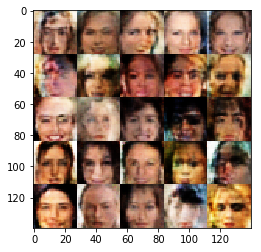

Epoch 1/1 - Step 3005/3165:  Discriminator Loss: 1.1506118774414062 Generator Loss: 0.7554949522018433
Epoch 1/1 - Step 3010/3165:  Discriminator Loss: 0.8340089321136475 Generator Loss: 1.4858946800231934
Epoch 1/1 - Step 3015/3165:  Discriminator Loss: 0.4123007655143738 Generator Loss: 2.1016159057617188
Epoch 1/1 - Step 3020/3165:  Discriminator Loss: 0.9802509546279907 Generator Loss: 1.1778295040130615
Epoch 1/1 - Step 3025/3165:  Discriminator Loss: 1.952567219734192 Generator Loss: 0.2947726249694824
Epoch 1/1 - Step 3030/3165:  Discriminator Loss: 0.7949432134628296 Generator Loss: 2.35746431350708
Epoch 1/1 - Step 3035/3165:  Discriminator Loss: 1.517346739768982 Generator Loss: 2.708657741546631
Epoch 1/1 - Step 3040/3165:  Discriminator Loss: 1.0440013408660889 Generator Loss: 0.7195785641670227
Epoch 1/1 - Step 3045/3165:  Discriminator Loss: 0.7168470621109009 Generator Loss: 1.4813950061798096
Epoch 1/1 - Step 3050/3165:  Discriminator Loss: 1.0053906440734863 Generator 

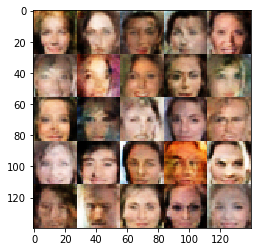

Epoch 1/1 - Step 3105/3165:  Discriminator Loss: 0.5044757723808289 Generator Loss: 2.0658950805664062
Epoch 1/1 - Step 3110/3165:  Discriminator Loss: 1.1943835020065308 Generator Loss: 0.9926975965499878
Epoch 1/1 - Step 3115/3165:  Discriminator Loss: 0.6748027801513672 Generator Loss: 1.5494745969772339
Epoch 1/1 - Step 3120/3165:  Discriminator Loss: 1.1423636674880981 Generator Loss: 0.5789963006973267
Epoch 1/1 - Step 3125/3165:  Discriminator Loss: 1.0925029516220093 Generator Loss: 0.7196596264839172
Epoch 1/1 - Step 3130/3165:  Discriminator Loss: 0.7386906147003174 Generator Loss: 2.6334750652313232
Epoch 1/1 - Step 3135/3165:  Discriminator Loss: 1.0841827392578125 Generator Loss: 0.7008464336395264
Epoch 1/1 - Step 3140/3165:  Discriminator Loss: 0.35522425174713135 Generator Loss: 2.6364426612854004
Epoch 1/1 - Step 3145/3165:  Discriminator Loss: 0.7859196066856384 Generator Loss: 2.3762927055358887
Epoch 1/1 - Step 3150/3165:  Discriminator Loss: 1.2386212348937988 Gene

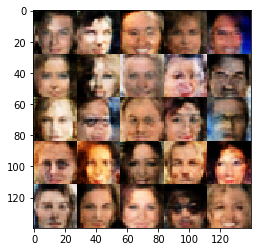

In [50]:
batch_size = 64
z_dim = 200
learning_rate = 0.00025
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.